This example was taken from the book **The Essence of Chaos** by *Edward Lorenz*. The aim of the model he presented in that chapter is to show how we can construct parsimonious models from real case phenomenons that exhibit chaos. 

The model consists of a board that goes down a regularly-bumpy slope or moguls without any control of the direction whatsoever. The dynamical system of this board is described by the system of ODE shown bellow

$$\frac{dx}{dt} = U, \quad \frac{dx}{dt} = V, \quad \frac{dz}{dt} = W.$$

\begin{align}
\frac{du}{dt} &= -F \partial_x H - cu, \\
\frac{dv}{dt} &= -F \partial_y H - cv, \\
\frac{dw}{dt} &= -g + F - cw.
\end{align}

\begin{align}
\frac{d \vec{u}}{dt} &= -F \nabla_H H - c \vec{u}.\\
\end{align}


$\vec{x} = (x,y,z)$ are the spacial coordinates and $\vec{u} = (u,v,w)$ are the components of the velocity of the board. And $H$ is the shape pf the slope that is parameterized by the following expression: 

$$H(x,y) = -ax - b \ cos(px) \ cos(qy).$$

In [4]:
using Plots

In [5]:
a = 0.25
b = 0.5
q = (2π)/4.0
p = (2π)/10.0

"""
    slope_parametrization(x,y) = -a*x .- b*cos(p*x).*cos(q*y)

Function with the parametrization of the slope with moguls.

"""
slope_parametrization(x,y) = -a*x .- b*cos(p*x).*cos(q*y)

slope_parametrization

In [6]:
"""
    generate_slope(G::Function, xx_range, yy_range)

Generates a grid like structure with a function G, in the domain x times y given by xx_range and yy_range.

"""
function generate_slope(G::Function, xx_range, yy_range)
    
    slope = zeros(length(x_range), length(y_range))
    
    for i in 1:length(xx_range)
        for j in 1:length(xx_range)
            
            slope[i,j] = G(xx_range[i], yy_range[j])
            
        end
    end
    
    slope
    
end

generate_slope


**WARNING! The surface plot takes too long. Avoid it if you are in a rush.**


``` Julia
gr()
x_range = 0:0.2:20
y_range = 0:0.2:20
sol = generate_slope(slope_parametrization, x_range, y_range)

surface(-x_range, -y_range, sol, color=:Blues)
xlabel!("x")
ylabel!("y")
title!("Moguls")

```

![](fig/shape_of_moguls.png)

*from the Python notebook.

# Boards down the slope!

Our first goal is to solve the ODE system for a given initial condition using a numerical integration method. For this, we declare a function containing the right-hand side terms of the ODE system that we want to solve. 

In [7]:
"""
    board(X_0::Array, b::Float64)

Right-hand-side of the equations for a board going down a slope with moguls.

`X_0` is the the set of initial conditions containing `[x, y, u, v]`, in that oder.
`b` is the height parameter of the moguls.
"""
function board(X_0::Array, b::Float64)
    
    x0 = copy(X_0[1])
    y0 = copy(X_0[2])
    u0 = copy(X_0[3])
    v0 = copy(X_0[4])
    
    g = 9.81
    c = 0.5
    a = 0.25
    p = (2*π)/10.0
    q = (2*π)/4.0
    
    H = -a*x0 - b*cos(p*x0)*cos(q*y0) 
    H_x = -a + b*p*sin(p*x0)*cos(q*y0)
    H_xx = b*p^2 * cos(p*x0)*cos(q*y0)
    H_y = b*q*cos(p*x0)*sin(q*y0)
    H_yy = b*q^2 * cos(p*x0)*cos(q*y0)
    H_xy = -b*q*p*sin(p*x0)*sin(q*y0)
        
    F = (g + H_xx*u0^2 + 2*H_xy*u0*v0 + H_yy*v0^2)/(1 + H_x^2 + H_y^2)
    
    dU = -F*H_x - c*u0
    dV = -F*H_y - c*v0
    
    return [u0, v0, dU, dV]
    
end

board

We use the fourth-order **Runge-Kutta method** as an integrator and we wrap it around the `solver` function. 

In [8]:
"""
    runge_kutta_step(f::Function, x0, dt::Float64, t=nothing)

Computes a step using the Runge-Kutta 4th order method.

`f` is a RHS function, `x0` is an array of variables to solve, 
`dt` is the timestep, and `t` correspond to an extra paramameter of
of the RHS.
"""
function runge_kutta_step(f::Function, x0, dt::Float64, t=nothing)
       
    k1 = f(x0, t) * dt
    k2 = f(x0 + k1/2, t) * dt
    k3 = f(x0 + k2/2, t) * dt
    k4 = f(x0 + k3, t) * dt
    x_new = x0 + (k1 + 2*k2 + 2*k3 + k4)/6
    
    return x_new
end

runge_kutta_step

In [9]:
"""
    solver(f::Function, x0::Array, y0::Array, v0::Array, u0::Array, dt::Float64, N_t::Int, N::Int, b = 0.5)

Function iterate the solution using `runge_kutta_step` and a RHS function `f`, for several points or initial 
conditions given by `N`.

`f` is a RHS function

`x0`, `y0`, `v0`, `u0` are arrays containig the initial condition x,y,v,u; with `N` dimensions.

`dt` is the timestep, 

`N_t` number of time steps.

`N` number of initial conditions to iterate.

`b` height of the moguls, parameter fixed.
"""
function solver(f::Function, x0::Array, y0::Array, v0::Array, u0::Array, dt::Float64, N_t::Int, N::Int, b = 0.5)
    
    solution = zeros(4, N_t+1, N)
    solution[1, 1, :] = x0
    solution[2, 1, :] = y0
    solution[3, 1, :] = u0
    solution[4, 1, :] = v0
    
    for i in 2:N_t + 1
        for k in 1:N
            
            x_0_step = solution[:, i-1, k]
            solution[:, i, k] = runge_kutta_step(f, x_0_step, dt, b)
        end
    end
         
    return solution
end

solver

In [10]:
"""
    plot_several_position(A, N)

Function to plot several trajectories of boards or sleds. 

`A` is the array with the solutions of the ensemble of points.

`N` is the number of members of the ensemble. 
"""
function plot_several_position(A, N)
    
    plot(A[2,:,1], A[1,:,1], yflip=true, size =(300, 600), leg = false, border = :box, dpi = 100)
    xlabel!("y (m)")
    ylabel!("x (m)")
    for i in 2:N
        plot!(A[2,:,i], A[1,:,i])
    end
    plot!()
end

plot_several_position

So now that we have our solver we can crush some snow with our boards in the moguls! 

### Example 1

Initial conditions: $x = 0.0$, $y = [0,1]$ (randomly chosen), $U = 3.5$ and $V = 0$.

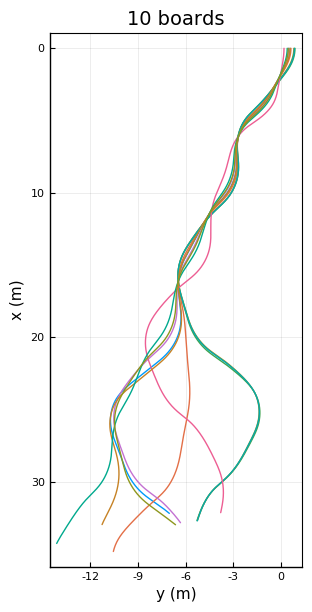

In [69]:
n_sleds = 10
n_time = 1000
x_init = zeros(n_sleds)
y_init = rand(n_sleds)
v_init = zeros(n_sleds)
u_init = zeros(n_sleds) .+ 3.5

sol_ex_1 = solver(board, x_init, y_init, v_init, u_init, 0.01, n_time, n_sleds);

pyplot()
plot_several_position(sol_ex_1, n_sleds)
title!("10 boards")
savefig("fig/bords_rand")

### Example 2

Initial conditions: $x = 0.0$, $y = [0,1]$ scattered evenly, $U = 4.0$ and $V = 2.0$.

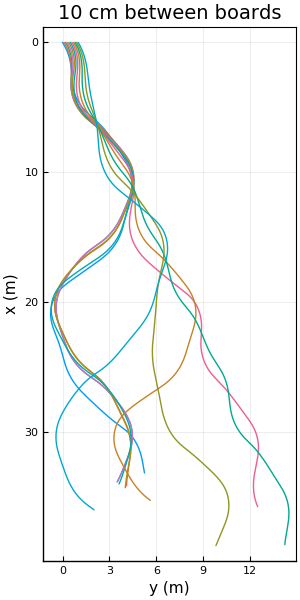

In [68]:
n_sleds = 11
n_time = 1000
x_init = zeros(n_sleds)
y_init = collect(0:0.1:1)
v_init = zeros(n_sleds) .+ 2.0 #zeros(n_sleds)
u_init = zeros(n_sleds) .+ 4.0

sol_ex_2 = solver(board, x_init, y_init, v_init, u_init, 0.01, n_time, n_sleds)

plot_several_position(sol_ex_2, n_sleds)
title!("10 cm between boards")

We can see how the system behaves chaotically, i.e if we vary a little the initial conditions, the trajectories of the boards diverge after 10 m downslope.

### Example 3
Initial conditions just spaced $1$mm apart from $0.497$m to $0.503$m.

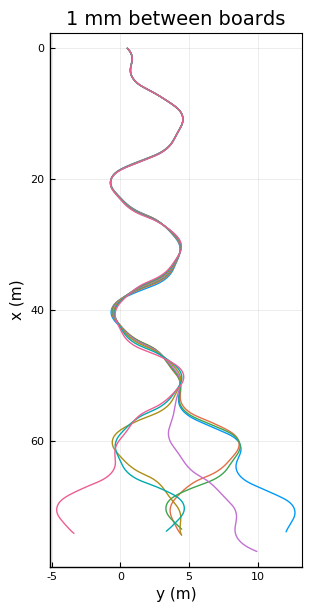

In [66]:
y_init = collect(0.497:0.001:0.503)
n_sleds = length(y_init)

n_time = 2200
x_init = zeros(n_sleds)
v_init = zeros(n_sleds) .+ 2.0 #zeros(n_sleds)
u_init = zeros(n_sleds) .+ 4.0

sol_ex_3 = solver(board, x_init, y_init, v_init, u_init, 0.01, n_time, n_sleds);

plot_several_position(sol_ex_3, n_sleds)
title!("1 mm between boards")
savefig("fig/boards_1mm")

The above shows that the system is sensitive to initial conditions but we would like to explore further the dynamics of the system. One of the technique for exploring the dynamics of the system is by plotting the phase space and see how the system behaves. The only problem is that for this system, there are 4 variables, which means that the phase space of the system lives in a four-dimensional space, which is not possible for us to visualize. We need to do some modifications to our board to reduce the dimensions of our system.


# Sleds down the slope!

To reduce the dimensions of our system, we can make the downslope velocity to be constants, or in the real world, by equipping our board with some brakes and an engine so it can maintain a constant velocity while going down the pits or up the bumps. In a mathematical sense, we say that $\partial_t U = 0$.

In [17]:
"""
    sled(X_0::Array, b::Float64)

Right-hand-side of the equations for a sled, with constant downward velocity, 
going down a slope with moguls.

`X_0` is the the set of initial conditions containing `[x, y, u, v]`, in that oder.

`b` is the height parameter of the moguls.
"""
function sled(X_0::Array, b::Float64)
    
    x0 = copy(X_0[1])
    y0 = copy(X_0[2])
    u0 = copy(X_0[3])
    v0 = copy(X_0[4])
    
    g = 9.81
    c = 0.5
    a = 0.25
    p = (2*π)/10.0
    q = (2*π)/4.0
    
    H = -a*x0 - b*cos(p*x0)*cos(q*y0) 
    H_x = -a + b*p*sin(p*x0)*cos(q*y0)
    H_xx = b*p^2 * cos(p*x0)*cos(q*y0)
    H_y = b*q*cos(p*x0)*sin(q*y0)
    H_yy = b*q^2 * cos(p*x0)*cos(q*y0)
    H_xy = -b*q*p*sin(p*x0)*sin(q*y0)
        
    F = (g + H_xx*u0^2 + 2*H_xy*u0*v0 + H_yy*v0^2)/(1 + H_x^2 + H_y^2)
    
    dU = 0
    dV = -F*H_y - c*v0
    
    return [u0, v0, dU, dV]
    
end

sled

Let's try it.

Initial conditions $x = 0$ m, $y = [0, 0.1]$ m, $v = 2$ m/s and $u = 3.5$ m/s.

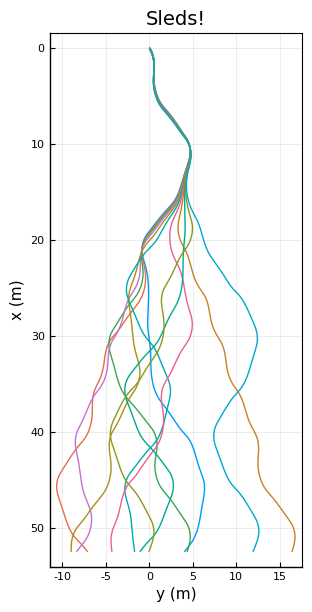

In [67]:
n_sleds = 11
n_time = 1500
x_init = zeros(n_sleds)
y_init = collect(0:0.01:0.1)
v_init = zeros(n_sleds) .+ 2.0 #zeros(n_sleds)
u_init = zeros(n_sleds) .+ 3.5

sol_sled = solver(sled, x_init, y_init, v_init, u_init, 0.01, n_time, n_sleds);

plot_several_position(sol_sled, n_sleds)
title!("Sleds!")
savefig("fig/sleds")

We see that the system behaves chaotically even though the downslope speed is maintained. 

# Sleds and strange attractors

Now our system has 3 variables, which will allow us to plot it phase space. The only problem now is that the system is no compact, because $x$ and $y$ can grow or decrease infinitively. Although, the cross slope velocity $v$ is bounded between $-5$ m/s and $5$ m/s, because of friction.

A way to do this is reducing the slope to be $x \in [-5, 5]$ m and $y \in [-2, 2]$ m, and set the boundaries to be periodic. This way, we will be able to compact the position of the sled without altering the physics of the system. 

![](fig/shape_of_moguls_compact.png)

In [20]:
"""
    compactor(x, lower_bound, upper_bound)

Funtion that maps any point outside the interval [`lower_bound`, `upper_bound`] 
to a point in the interval, preserving length. If the point is in the interval,
it does not change.

`x` point in question to be evaluated.

`lower_bound` lower bound of the interval.

`upper_bound` upper bound of the interval.
"""
function compactor(x, lower_bound, upper_bound)
    
    if x > upper_bound
        return x%upper_bound - upper_bound
        
    elseif x < lower_bound 
        return x%lower_bound - lower_bound
        
    else
        return x
        
    end
end

compactor

In [21]:
"""
    solver_compact(f::Function, x0::Array, y0::Array, v0::Array, u0::Float64, dt::Float64, N_t::Int, N::Int, b = 0.5)

Function iterate the solution using `runge_kutta_step` and a RHS function `f`, for several points or initial 
conditions given by `N`, in compact domain. 

`f` is a RHS function

`x0`, `y0`, `v0`, `u0` are arrays containig the initial condition x,y,v,u; with `N` dimensions.

`dt` is the timestep, 

`N_t` number of time steps.

`N` number of initial conditions to iterate.

`b` height of the moguls, parameter fixed.
"""
function solver_compact(f::Function, x0::Array, y0::Array, v0::Array, u0::Float64, dt::Float64, N_t::Int, N::Int, b = 0.5)
    
    solution = zeros(3, N_t+1, N)
    solution[1, 1, :] = x0
    solution[2, 1, :] = y0
    solution[3, 1, :] = v0
    
    for i in 2:N_t+1
        for k in 1:N
            
            x_0_step = insert!(solution[:, i-1, k], 3, u0)
            
            aux = runge_kutta_step(f, x_0_step, dt, b)
            solution[1, i, k] = compactor(aux[1], -5, 5)
            solution[2, i, k] = compactor(aux[2], -2, 2)
            solution[3, i, k] = aux[4]
        
        end   
    end

    return solution
end

solver_compact

Lets give it a go. 

In [22]:
n_sleds = 1
n_time = 1000
x_init = zeros(n_sleds)
y_init = rand(n_sleds).*4 .- 2
v_init = rand(n_sleds).*10 .- 5

@time sol_compact = solver_compact(sled, x_init, y_init, v_init, 3.5, 0.01, n_time, n_sleds);

  0.063590 seconds (139.77 k allocations: 6.985 MiB)


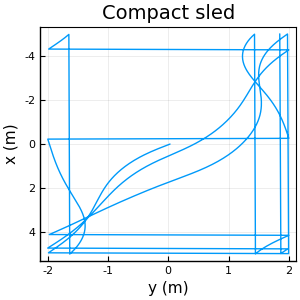

In [23]:
plot(sol_compact[2,:,1], sol_compact[1,:,1], yflip=true, size =(300, 300), leg = false, border = :box)
xlabel!("y (m)")
ylabel!("x (m)")
title!("Compact sled")

We can see how the sled goes out of the domain and re-enters at the opposite side. 

The main interest of this is to build a strange attractor. For this, we set a ensemble of sled all starting from $x = 0$m, but with random $y$ and cross slope velocities $v$, with $u$ set to 3.5 m.

In [24]:
n_sleds = 1000
n_time = 1000
x_init = zeros(n_sleds)
y_init = rand(n_sleds).*4 .- 2
v_init = rand(n_sleds).*10 .- 5

@time sol_compact_1000 = solver_compact(sled, x_init, y_init, v_init, 3.5, 0.01, n_time, n_sleds);

 18.498905 seconds (66.00 M allocations: 3.226 GiB, 4.84% gc time)


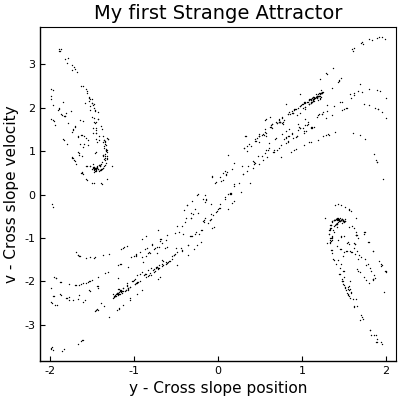

In [25]:
st = 1000
scatter(sol_compact_1000[2, st, :], sol_compact_1000[3, st, :], markersize = 1, legend=false, 
    markercolor= :black, grid = false, size =(400, 400), 
    markerstrokewidth=0, border = :box)

xlabel!("y - Cross slope position")
ylabel!("v - Cross slope velocity")
title!("My first Strange Attractor")

We have an attractor!

## Optimized function

As you saw in the last lines, the computation of several sled trajectories takes quite a lot of memory and time, probably because of the way the code is written. That is way I wrote an optimized code, which is messier that the last one but it runs quite fast using much less memory. This will allow us to increase the simulation times and the number of sleds in our ensemble.

In [26]:
"""
    dV(v0, F, H_y, c)

Right hand side equation of the change of the cross-slope velocity.
"""
dV(v0, F, H_y, c) = -F*H_y - c*v0 

"""
    runge_kutta_step_2(f::Function, x0, dt, F, H, c)

Computes the runge kutta 4th order. made speciafically for the `sled_ensemble` function. 
"""
function runge_kutta_step_2(f::Function, x0, dt, F, H, c)
       
    k1 = f(x0, F, H, c) * dt
    k2 = f(x0 + k1/2, F, H, c) * dt
    k3 = f(x0 + k2/2, F, H, c) * dt
    k4 = f(x0 + k3, F, H, c) * dt
    x_new = x0 + (k1 + 2*k2 + 2*k3 + k4)/6
    
    return x_new
end

"""
    sled_ensemble(x0::Array, y0::Array, v0::Array, u0::Float64 , n::Int, dt::Float64, N::Int, b = 0.5)

Optimized solver for the sleds ensembles.

`x0`, `y0`, `v0` are arrays containig the initial condition x,y,v; with `N` dimensions.

`u0` is the downslope velocity, it must be a single number, not array.

`dt` is the timestep, 

`n` number of time steps.

`N` number of initial conditions to iterate.

`b` height of the moguls, parameter fixed to 0.5 m.
"""
function sled_ensemble(x0::Array, y0::Array, v0::Array, u0::Float64 , n::Int, dt::Float64, N::Int, b = 0.5)
    g = 9.81
    c = 0.5
    a = 0.25
    p = (2π)/10.0
    q = (2π)/4.0
   
    x_sol = zeros(N, n+1)
    y_sol = zeros(N, n+1)
    v_sol = zeros(N, n+1)
    
    x_sol[:, 1] = x0
    y_sol[:, 1] = y0
    v_sol[:, 1] = v0
    
    for i in 1:n
        for k in 1:N
                
            x_i = x_sol[k, i]
            y_i = y_sol[k, i]
            v_i = v_sol[k, i]

            H = -a*x_i - b*cos(p*x_i)*cos(q*y_i) 
            H_x = -a + b*p*sin(p*x_i)*cos(q*y_i)
            H_xx = b*p^2 * cos(p*x_i)*cos(q*y_i)
            H_y = b*q*cos(p*x_i)*sin(q*y_i)
            H_yy = b*q^2 * cos(p*x_i)*cos(q*y_i)
            H_xy = -b*q*p*sin(p*x_i)*sin(q*y_i)

            F = (g + H_xx*u0^2 + 2*H_xy*u0*v_i + H_yy*v_i^2)/(1 + H_x^2 + H_y^2)
            v_new = runge_kutta_step_2(dV, v_i, dt, F, H_y, c)
            x_new = compactor(x_i + u0 * dt, -5., 5.) 
            y_new = compactor(y_i + v_i*dt, -2, 2)

            x_sol[k, i+1] = x_new
            y_sol[k, i+1] = y_new
            v_sol[k, i+1] = v_new
                
        
        end
    end
    
    y_sol, v_sol
    
end

sled_ensemble

### Ten thousand sleds going down the slope!

In [41]:
n_sleds = 8000
n_time = 2500
x_init = zeros(n_sleds)
y_init = rand(n_sleds).*4 .- 2
v_init = rand(n_sleds)*10 .- 5;

@time y_compact, v_compact = sled_ensemble(x_init, y_init, v_init, 3.5, n_time, 0.01, n_sleds)

  4.712748 seconds (20 allocations: 572.434 MiB, 20.96% gc time)


([0.06619226005093637 0.09387627163177621 … -1.0743521506458842 -1.050968995857223; -0.9503743667535804 -0.94080969687149 … -1.9543752242344257 -1.9628079008920847; … ; 0.12315794042585448 0.10843154716598162 … -1.6413624723470397 -1.6479258877070202; -1.3953155652853448 -1.4299741041898122 … -0.7588887033605055 -0.7367553082859982], [2.768401158083984 2.738151897009314 … 2.3383154788661193 2.326356463369169; 0.956466988209046 0.9987117660595242 … -0.8432676657659105 -0.8391858320529331; … ; -1.472639325987286 -1.485845688259132 … -0.6563415359980442 -0.6540865801021886; -3.465853890446744 -3.4495169124438 … 2.213339507450733 2.2019280259330234])

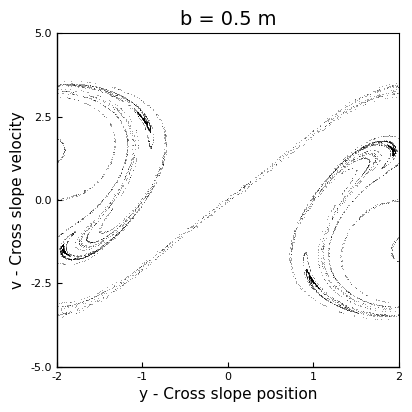

┌ Info: Saved animation to 
│   fn = /Users/claudiopierard/Projects/moguls_chaos/animations/b_05.gif
└ @ Plots /Users/claudiopierard/.julia/packages/Plots/AXUqs/src/animation.jl:98


Plots.AnimatedGif("/Users/claudiopierard/Projects/moguls_chaos/animations/b_05.gif")
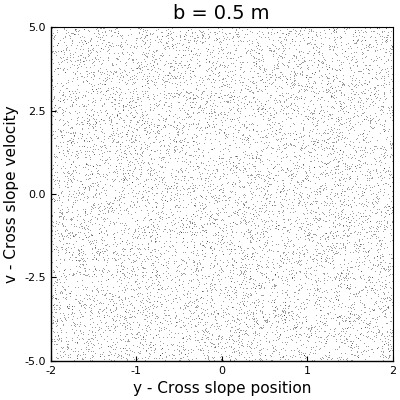

In [65]:
anim_b05 = @animate for i=1:2500
    
    scatter(y_compact[:, i], v_compact[:, i], 
        markersize = 0.5, legend=false,
        markercolor= :black, grid = false, markerstrokecolor = false,
        size =(400, 400), markerstrokewidth=0, border = :box)
    
    ylims!(-5,5)
    xlims!(-2,2)
    xlabel!("y - Cross slope position")
    ylabel!("v - Cross slope velocity")
    title!("b = 0.5 m")
    
end every 10

gif(anim_b05, "animations/b_05.gif", fps = 20)

### Moguls height b = 0.2 m

In [44]:
n_sleds = 8000
n_time = 2500
x_init = zeros(n_sleds)
y_init = rand(n_sleds).*4 .- 2
v_init = rand(n_sleds)*10 .- 5;

@time y_compact_02, v_compact_02 = sled_ensemble(x_init, y_init, v_init, 3.5, n_time, 0.01, n_sleds, 0.2)

  3.238687 seconds (19 allocations: 457.947 MiB, 1.39% gc time)


([-1.232960909382304 -1.2781668727041482 … -1.3200287739544563 -1.3088680494882448; 1.1100206003929296 1.156669958791477 … 1.3195485163840217 1.3083935571084668; … ; -0.20239741656334598 -0.19747266814674883 … -1.3132519951857078 -1.3021575397379623; 1.0805738848725497 1.0849146494954394 … 1.2915785562338036 1.2813895419343992], [-4.520596332184422 -4.483131555410413 … 1.1160724466211551 1.1100119656209142; 4.6649358398547385 4.620888617725718 … -1.1154959275554812 -1.1094381258902803; … ; 0.492474841659714 0.4999251565725807 … 1.1094455447745404 1.1034154760733603; 0.4340764622889708 0.4059718856006061 … -1.018901429940433 -1.0133097489424094])

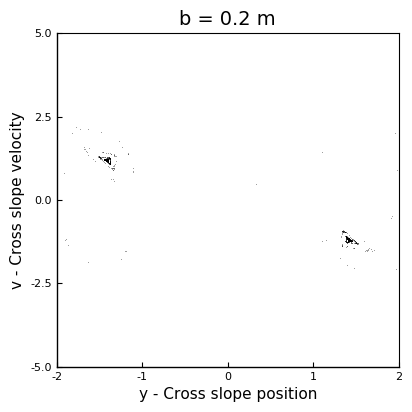

┌ Info: Saved animation to 
│   fn = /Users/claudiopierard/Projects/moguls_chaos/animations/b_02.gif
└ @ Plots /Users/claudiopierard/.julia/packages/Plots/AXUqs/src/animation.jl:98


Plots.AnimatedGif("/Users/claudiopierard/Projects/moguls_chaos/animations/b_02.gif")
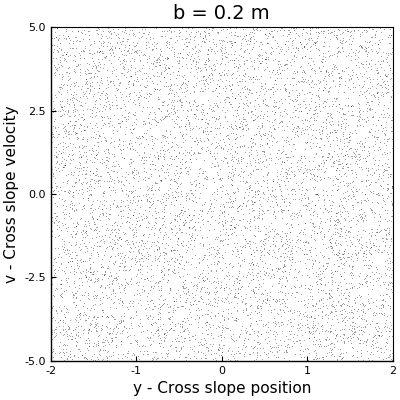

In [52]:
anim_b02 = @animate for i=1:2500
    
    scatter(y_compact_02[:, i], v_compact_02[:, i], 
        markersize = 0.5, legend=false, 
        markercolor= :black, grid = false, markerstrokecolor = false,
        size =(400, 400), markerstrokewidth=0, border = :box)
    
    ylims!(-5,5)
    xlims!(-2,2)
    xlabel!("y - Cross slope position")
    ylabel!("v - Cross slope velocity")
    title!("b = 0.2 m")
    
end every 10

gif(anim_b02, "animations/b_02.gif", fps = 20)

### Moguls height b = 0.66 m

In [46]:
n_sleds = 8000
n_time = 2500
x_init = zeros(n_sleds)
y_init = rand(n_sleds).*4 .- 2
v_init = rand(n_sleds)*10 .- 5;

@time y_compact_06, v_compact_06 = sled_ensemble(x_init, y_init, v_init, 3.5, n_time, 0.01, n_sleds, 0.66)

  3.853630 seconds (13 allocations: 457.947 MiB, 0.59% gc time)


([1.123578715898617 1.0947165265400798 … 0.9806084484625968 0.9777828167093577; -0.5372076083671207 -0.5036046272152197 … -1.6266883308348927 -1.6337052429701666; … ; 0.7144893013055587 0.684821288783355 … 1.5939934558794826 1.5736905653767144; 0.29421973165068493 0.32663609956162865 … 0.8913456156251869 0.8771803031487914], [-2.8862189358537282 -2.903646865301805 … -0.28256317532390657 -0.27934310629193865; 3.3602981151900924 3.455789300549904 … -0.701691213527391 -0.6996444637980372; … ; -2.9668012522203613 -3.0358337134434663 … -2.0302890502768216 -2.019561405721553; 3.241636791094372 3.1243579724842827 … -1.4165312476395502 -1.4087710838902405])

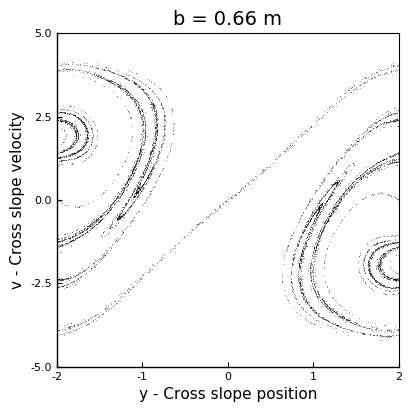

┌ Info: Saved animation to 
│   fn = /Users/claudiopierard/Projects/moguls_chaos/animations/b_06.gif
└ @ Plots /Users/claudiopierard/.julia/packages/Plots/AXUqs/src/animation.jl:98


Plots.AnimatedGif("/Users/claudiopierard/Projects/moguls_chaos/animations/b_06.gif")
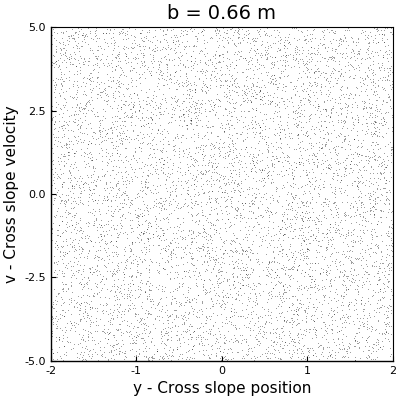

In [53]:
anim_b06 = @animate for i=1:2500
    
    scatter(y_compact_06[:, i], v_compact_06[:, i], 
        markersize = 0.5, legend=false, 
        markercolor= :black, grid = false, markerstrokecolor = false,
        size =(400, 400), markerstrokewidth=0, border = :box)
    
    ylims!(-5,5)
    xlims!(-2,2)
    xlabel!("y - Cross slope position")
    ylabel!("v - Cross slope velocity")
    title!("b = 0.66 m")
    
end every 10

gif(anim_b06, "animations/b_06.gif", fps = 20)

### Moguls height b = 0.11 m

In [48]:
n_sleds = 8000
n_time = 2500
x_init = zeros(n_sleds)
y_init = rand(n_sleds).*4 .- 2
v_init = rand(n_sleds)*10 .- 5;

@time y_compact_01, v_compact_01 = sled_ensemble(x_init, y_init, v_init, 3.5, n_time, 0.01, n_sleds, 0.011)

  3.652285 seconds (13 allocations: 457.947 MiB, 0.42% gc time)


([1.9895784732889403 -1.9996503818461666 … 0.04742409176376333 0.04746902190773041; -1.8065420337310574 -1.8212688791826572 … -0.5311969973524096 -0.5316664050705003; … ; 1.8566577808368026 1.8672692465293605 … -0.0900446206346928 -0.09012968243767126; 1.970080539271092 1.9845089459337781 … 0.6747335049933437 0.6753003941179503], [1.0771144864892985 1.0717165309362857 … 0.004493014396707738 0.004473200896986434; -1.4726845451599746 -1.464868524797553 … -0.04694077180908046 -0.046732527696146275; … ; 1.061146569255806 1.0555017484984333 … -0.008506180297845362 -0.008468671941092624; 1.4428406662686077 1.4355705415372944 … 0.056688912460658956 0.05643666046234604])

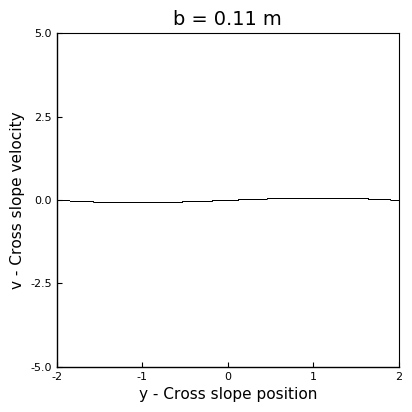

┌ Info: Saved animation to 
│   fn = /Users/claudiopierard/Projects/moguls_chaos/animations/b_01.gif
└ @ Plots /Users/claudiopierard/.julia/packages/Plots/AXUqs/src/animation.jl:98


Plots.AnimatedGif("/Users/claudiopierard/Projects/moguls_chaos/animations/b_01.gif")
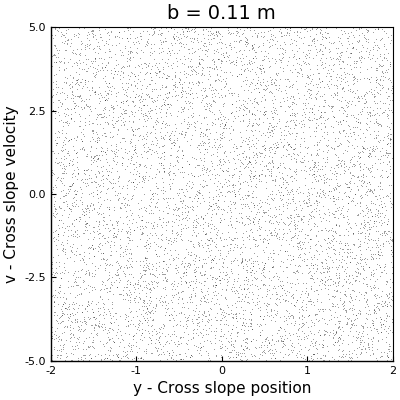

In [54]:
anim_b01 = @animate for i=1:2500
    
    scatter(y_compact_01[:, i], v_compact_01[:, i], 
        markersize = 0.5, legend=false, 
        markercolor= :black, grid = false, markerstrokecolor = false,
        size =(400, 400), markerstrokewidth=0, border = :box)
    
    ylims!(-5,5)
    xlims!(-2,2)
    xlabel!("y - Cross slope position")
    ylabel!("v - Cross slope velocity")
    title!("b = 0.11 m")
    
end every 10

gif(anim_b01, "animations/b_01.gif", fps = 20)

# Routes from Chaos

Now we see that the attractor changes if we change the height of the bumps in the slope, the parameter $b$. Especially, we can think that when $b = 0$ m, the sled will follow straight lines, which are non-chaotic, and as we increase $b$ this trajectories will transition to chaotic ones. 

A practical way of visualizing this is by a bifurcation diagram, in which we plot the state of the system according to a parameter which drives the system.

In the sled case, we can use the local maximum cross slope velocity, deleting the transient states, to visualize were the sled has a periodic behavior or a chaotic one



In [37]:
b_range = collect(0:0.0005:0.7)
k_transient = 7100

n_sleds = 1
n_time = 7800
x_init = zeros(n_sleds) 
y_init = rand(n_sleds) .- 0.5
v_init = zeros(n_sleds)

orbit = Float64[]
b_par = Float64[]


for b_i in b_range
    
    y_tmp, v_tmp = sled_ensemble(x_init, y_init, v_init, 3.5, n_time, 0.01, n_sleds, b_i)
    
    v_tmp = v_tmp[:, k_transient:end]'
    v_tmp = reshape(v_tmp, length(v_tmp))
    
    for i in 2:length(v_tmp)-1
        
        if v_tmp[i] > v_tmp[i-1] && v_tmp[i] > v_tmp[i+1] || v_tmp[i] < v_tmp[i-1] && v_tmp[i] < v_tmp[i+1]
            
            append!(orbit, v_tmp[i])
            append!(b_par, b_i)
            
        end
    end
end

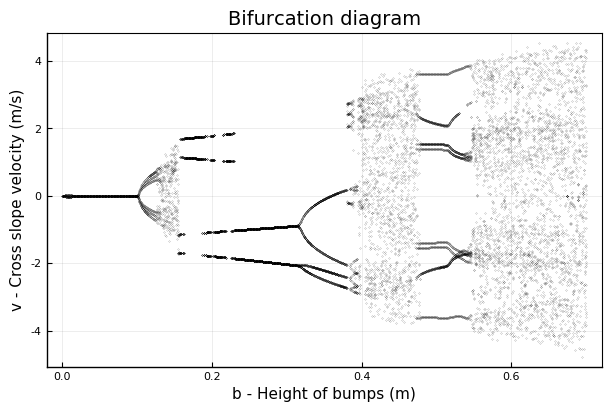

In [38]:
scatter(b_par, orbit, markersize=0.1, c=:black, leg=false, 
    xaxis=("b - Height of bumps (m)"), yaxis=("v - Cross slope velocity (m/s)"), border = :box)

title!("Bifurcation diagram")
savefig("fig/bifurcation_diagram_velocity")

We can see that there is axial symmetry with respect to $V = 0$ m/s. This means that the bifurcation diagram can be drawn in either the negative side of the velocities or the positive side, creating regions without point in the lower and upper part. 

We can correct this is we consider only the cross slope speed, i.e. take the absolute value of $V$.

In [39]:
b_range = collect(0:0.0001:0.7)
k_transient = 9600

n_sleds = 1
n_time = 10000
x_init = zeros(n_sleds) 
y_init = rand(n_sleds) .- 0.5
println("y initial = ", y_init)
v_init = zeros(n_sleds)

orbit = Float64[]
b_par = Float64[]


for b_i in b_range
    
    y_tmp, v_tmp = sled_ensemble(x_init, y_init, v_init, 3.5, n_time, 0.01, n_sleds, b_i)
    
    v_tmp = v_tmp[:, k_transient:end]'
    v_tmp = reshape(v_tmp, length(v_tmp))
    
    for i in 2:length(v_tmp)-1
        
        if v_tmp[i] > v_tmp[i-1] && v_tmp[i] > v_tmp[i+1] || v_tmp[i] < v_tmp[i-1] && v_tmp[i] < v_tmp[i+1]
            
            append!(orbit, abs(v_tmp[i]))
            append!(b_par, b_i)
            
        end
    end
end

y initial = [0.2039152920099252]


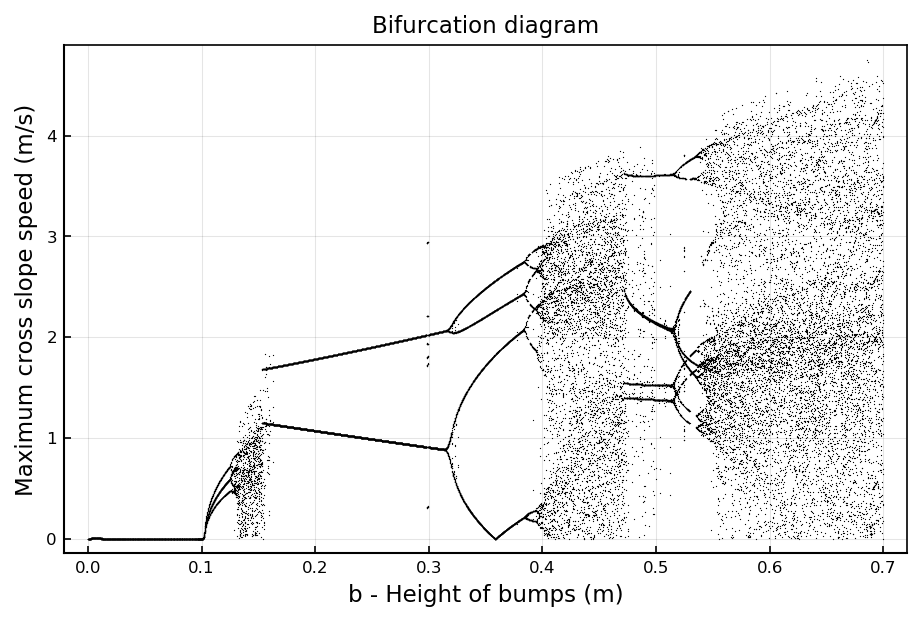

In [40]:
p1 = scatter(b_par, orbit, markersize=0.6, markerstrokecolor=false, c=:black, leg=false, 
    xaxis=("b - Height of bumps (m)"), yaxis=("Maximum cross slope speed (m/s)"), border = :box, dpi = 150)

xticks!(0:0.1:0.7)
title!("Bifurcation diagram", titlefontsize = 11)
savefig("fig/bifurcation_diagram_speed")

The regions with clouds of points are the chaotic ones. The regions where there are only lines, indicate states in which the sled reaches an periodic trajectory. Is possible to see that from 0.4 the sled trajectories are chaotic, with an apparent periodicity between $b = 0.5$ m and $b = 0.6$ m. Although, this bifurcation diagrams are highly dependent in the initial condition given, and they may change according to this.


# References

- Lorenz, Edward N. *The Essence of Chaos*. Univ. of Washington Press, 1993.